In [1]:
from utils.helpers import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
np.random.seed(0)

### Risk Model
$$\Sigma = \beta\Omega\beta' + D $$ 

In [3]:
# factor loadings
beta = np.array([[0.9,0,0.5],
                 [1.1,0.5,0], 
                 [1.2,.3,.2],
                 [.8,.1,.7]])

# factor covariance matrix
factor_sigma = np.array([.2,.1,.1])
factor_corr = np.identity(len(factor_sigma))
Omega = factor_corr * (factor_sigma[:,None] @ factor_sigma[:,None].T)

# idiosyncratic covariance matrix
idio_vols = np.array([.1,.15,.1,.15])
D = np.diag(idio_vols**2)

# asset covariance matrix
Sigma = beta@Omega@beta.T+D

# inverse matrices (to avoid computation over again, useful for factor risk contributions of a given portfolio)
pseudo_inv_beta = beta@np.linalg.inv(beta.T@beta)
inv_cov = np.linalg.inv(Sigma)
matrix_min_vol = inv_cov@beta@np.linalg.inv(beta.T@inv_cov@beta) 

d, m = beta.shape

if np.linalg.matrix_rank(beta)!=m:
    raise ValueError('The factor loadings matrix is NOT full rank!')

if is_pos_def(Sigma)==False:
    raise ValueError('The covariance matrix is NOT PSD!')

print('======================================================')
print('Number of assets:', d)
print('Number of factors:', m)
print('======================================================')
print('Betas:', beta)
print('======================================================')
print('Covariance matrix:', Sigma)

Number of assets: 4
Number of factors: 3
Betas: [[0.9 0.  0.5]
 [1.1 0.5 0. ]
 [1.2 0.3 0.2]
 [0.8 0.1 0.7]]
Covariance matrix: [[0.0449 0.0396 0.0442 0.0323]
 [0.0396 0.0734 0.0543 0.0357]
 [0.0442 0.0543 0.0689 0.0401]
 [0.0323 0.0357 0.0401 0.0531]]


### How to choose the importance parameters?

In the case of Asset-Factor Risk Budgeting, we are dealing with the following problem:

$$ \min_{y \in \mathcal C^{> 0}} y'\Sigma y  -  \lambda_a \sum_{i=1}^d {b_a}_i \log{y_i} - \lambda_f \sum_{i=1}^m {b_f}_i \log{(\beta'y)_i}$$
where $\mathcal C^{>0} = \big\{y\in(\mathbb R_+^*)^d | (\beta'y)_i>0, \forall i \in \{1,\ldots,m\}\big\}$ and $\lambda_a, \lambda_f \in \mathbb R_+^*$ are asset and factor importance parameters. 

As portfolio managers, we may have strong views on the desired risk budgets ($b_a$ and $b_f$) for both the assets in the portfolio and the factors driving them (e.g., equal risk budgets). However, it remains unclear which should be prioritized, a choice that can be reflected in this framework through the tuning of $\lambda_a$ and $\lambda_f$. 

An interesting analysis would be to examine how far the resulting asset and factor risk contributions deviate from the targets ($b_a$ and $b_f$) for different values of $\lambda_a$ and $\lambda_f$. 

Relative entropy can be an interesting measure to quantify such deviations, where low-relative entropy regions indicate proximity to the chosen risk budgets.

#### Grid search

In [4]:
# Asset and factor risk budgets (chosen equal)
factor_budgets = np.ones(m)/m
asset_budgets = np.ones(d)/d

# Initialize dataframes 
df_risk = pd.DataFrame(columns=['lambda_a', 'lambda_f', 'risk'])
df_asset_risk_contrib = pd.DataFrame(columns=['lambda_a', 'lambda_f', 'risk'])
df_factor_risk_contrib = pd.DataFrame(columns=['lambda_a', 'lambda_f', 'risk'])

i = 0
for asset_coef in tqdm(np.linspace(0.01,.3, 100)):
    for factor_coef in np.linspace(0.01,1, 100):
        # Compute the AFERC portfolio
        _, theta_asset_factor_erc = compute_asset_factor_risk_budgeting_portfolio(asset_budgets, factor_budgets, asset_coef, factor_coef, beta, Sigma)
        w_asset_factor_erc = theta_asset_factor_erc@beta

        # Compute asset risk contributions
        port_risk = vol(theta_asset_factor_erc, Sigma)
        vol_contrib = asset_vol_contribution(theta_asset_factor_erc, Sigma)
        vol_contrib = vol_contrib/sum(vol_contrib)

        # Compute factor risk contributions
        factor_risk_contrib = w_asset_factor_erc*grad_factor_risk_measure_volatility_analytical(w_asset_factor_erc, matrix_min_vol, pseudo_inv_beta, Sigma)
        factor_risk_contrib = factor_risk_contrib/sum(factor_risk_contrib)

        # Compute the relative entropy (how much risk contributions deviate from the budgets)
        df_risk.loc[i] = np.array([asset_coef, factor_coef, port_risk])
        df_asset_risk_contrib.loc[i] = np.array([asset_coef, factor_coef, relative_entropy(vol_contrib,asset_budgets)])
        df_factor_risk_contrib.loc[i] = np.array([asset_coef, factor_coef, relative_entropy(factor_risk_contrib,factor_budgets)])

        i+=1

100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


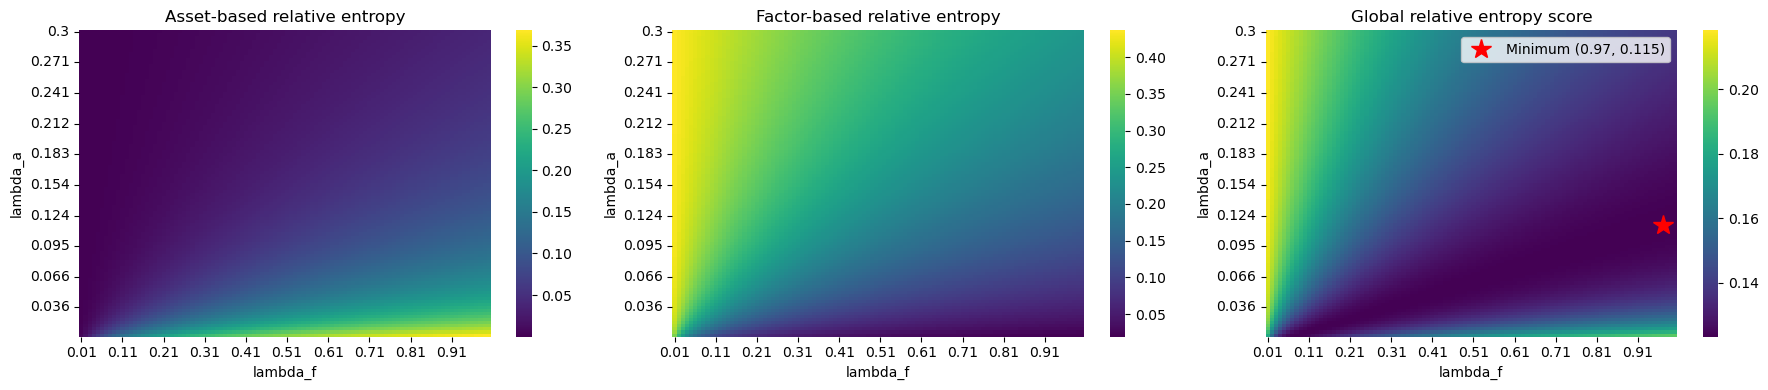

In [5]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1,3, figsize=(3*6,4))

df_total_risk_contrib = pd.DataFrame(columns=['lambda_a', 'lambda_f', 'risk'])
df_total_risk_contrib['lambda_a'] = df_asset_risk_contrib['lambda_a']
df_total_risk_contrib['lambda_f'] = df_asset_risk_contrib['lambda_f']
df_total_risk_contrib['risk'] = (df_asset_risk_contrib['risk'] + df_factor_risk_contrib['risk'])/2

df_asset_risk_contrib_viz = df_asset_risk_contrib.copy()
df_asset_risk_contrib_viz[['lambda_a', 'lambda_f']] = df_asset_risk_contrib_viz[['lambda_a', 'lambda_f']].round(3)
df_asset_risk_contrib_viz.columns = ['lambda_a', 'lambda_f', None]
df_asset_risk_contrib_viz = df_asset_risk_contrib_viz.set_index(['lambda_a', 'lambda_f']).unstack()
df_asset_risk_contrib_viz.columns = df_asset_risk_contrib_viz.columns.get_level_values(1)

df_factor_risk_contrib_viz = df_factor_risk_contrib.copy()
df_factor_risk_contrib_viz[['lambda_a', 'lambda_f']] = df_factor_risk_contrib_viz[['lambda_a', 'lambda_f']].round(3)
df_factor_risk_contrib_viz.columns = ['lambda_a', 'lambda_f', None]
df_factor_risk_contrib_viz = df_factor_risk_contrib_viz.set_index(['lambda_a', 'lambda_f']).unstack()
df_factor_risk_contrib_viz.columns = df_factor_risk_contrib_viz.columns.get_level_values(1)

df_total_risk_contrib_viz = df_total_risk_contrib.copy()
df_total_risk_contrib_viz[['lambda_a', 'lambda_f']] = df_total_risk_contrib_viz[['lambda_a', 'lambda_f']].round(3)
df_total_risk_contrib_viz.columns = ['lambda_a', 'lambda_f', None]
df_total_risk_contrib_viz = df_total_risk_contrib_viz.set_index(['lambda_a', 'lambda_f']).unstack()
df_total_risk_contrib_viz.columns = df_total_risk_contrib_viz.columns.get_level_values(1)

sns.heatmap(df_asset_risk_contrib_viz.iloc[::-1,:], xticklabels = 10, yticklabels = 10, cmap="viridis", ax=ax[0])
sns.heatmap(df_factor_risk_contrib_viz.iloc[::-1,:], xticklabels = 10, yticklabels = 10, cmap="viridis", ax=ax[1])
sns.heatmap(df_total_risk_contrib_viz.iloc[::-1,:], xticklabels = 10, yticklabels = 10, cmap="viridis", ax=ax[2])

min_y = df_total_risk_contrib.loc[df_total_risk_contrib['risk'].argmin()].lambda_a
min_x = df_total_risk_contrib.loc[df_total_risk_contrib['risk'].argmin()].lambda_f

min_y = round(min_y, 3)
min_x = round(min_x, 3)

# Get the matrix positions in the heatmap
x_pos = df_total_risk_contrib_viz.columns.get_loc(min_x)

# Because you reversed rows with iloc[::-1], the y index is flipped:
y_pos = df_total_risk_contrib_viz.index.get_loc(min_y)
y_pos = len(df_total_risk_contrib_viz.index) - 1 - y_pos

# Plot the star at the right matrix cell (with +0.5 for center)
ax[2].plot(x_pos + 0.5, y_pos + 0.5, marker='*', color='red', markersize=15, label='Minimum')

ax[0].set_title('Asset-based relative entropy', fontsize=12)
ax[1].set_title('Factor-based relative entropy', fontsize=12)
ax[2].set_title('Global relative entropy score', fontsize=12)

# Create custom legend handle for the star only
star_handle = Line2D([0], [0], marker='*', color='red', linestyle='None', markersize=15, label='Minimum' + f' ({min_x}, {min_y})')

# Add legend with the custom handle
ax[2].legend(handles=[star_handle], loc='upper right')

fig.tight_layout()

In [6]:
### Asset-Factor ERC portfolios

### Optimization problem for Asset-Factor ERC portfolio
# factor risk budgets (chosen equal) and asset risk budgets (chosen equal)
factor_budgets = np.ones(m)/m
asset_budgets = np.ones(d)/d

# factor and asset "importance" parameters to obtain the minimum relative entropy score 
factor_coef = .97
asset_coef = .115

_, theta_aferc = compute_asset_factor_risk_budgeting_portfolio(asset_budgets,
                                                               factor_budgets,
                                                               asset_coef,
                                                               factor_coef,
                                                               beta,
                                                               Sigma)

# factor allocations of the computed portfolio
w_aferc = theta_aferc@beta
# asset and factor risk contributions
rc_aferc = asset_vol_contribution(theta_aferc, Sigma)
frc_aferc =  w_aferc*grad_factor_risk_measure_volatility_analytical(w_aferc, matrix_min_vol, pseudo_inv_beta, Sigma)

In [7]:
print('======================================================')
print('Asset-Factor ERC portfolio (lambda_a = %.3f, lambda_f = %.3f)' % (asset_coef, factor_coef))
print('======================================================')
print('Asset weights:', theta_aferc.round(3))
print('Factor weights:', w_aferc.round(3))
print('Asset risk contributions:', rc_aferc.round(3))
print('Factor risk contributions:', frc_aferc.round(3))
print('Portfolio volatility:', vol(theta_aferc, Sigma).round(3))
print('======================================================')

Asset-Factor ERC portfolio (lambda_a = 0.115, lambda_f = 0.970)
Asset weights: [0.14  0.274 0.156 0.43 ]
Factor weights: [0.959 0.227 0.402]
Asset risk contributions: [0.025 0.064 0.036 0.088]
Factor risk contributions: [0.125 0.039 0.048]
Portfolio volatility: 0.213


### Bayesian optimization 

Instead of an exhaustive grid search, a better approach is to use Bayesian optimization to find the optimal pair ($\lambda_a$, $\lambda_f$). This time, we use the L2 norm as the proximity measure.

In [8]:
import optuna

def objective(trial):
    # find the optimal lambda_a parameter for a fixed lambda_f (what is important is the relative magnitude of the two parameters, so we can fix one of them)
    lamdba_a = trial.suggest_float('lamdba_a', 1e-10, 5)

    # Asset and factor risk budgets (chosen equal)
    factor_budgets = np.ones(m)/m
    asset_budgets = np.ones(d)/d

    _, theta_aferc = compute_asset_factor_risk_budgeting_portfolio(asset_budgets,
                                                               factor_budgets,
                                                               lamdba_a,
                                                               1,
                                                               beta,
                                                               Sigma)
    # factor allocations of the computed portfolio
    w_asset_factor_erc = theta_aferc@beta

    # Compute asset risk contributions
    vol_contrib = asset_vol_contribution(theta_aferc, Sigma)
    vol_contrib = vol_contrib/sum(vol_contrib)

    # Compute factor risk contributions
    factor_risk_contrib = w_asset_factor_erc*grad_factor_risk_measure_volatility_analytical(w_asset_factor_erc, matrix_min_vol, pseudo_inv_beta, Sigma)
    factor_risk_contrib = factor_risk_contrib/sum(factor_risk_contrib)

    return np.linalg.norm(asset_budgets - vol_contrib)**2*d + np.linalg.norm(factor_budgets - factor_risk_contrib)**2*m
    # return relative_entropy(vol_contrib,asset_budgets) + relative_entropy(factor_risk_contrib,factor_budgets)

study = optuna.create_study()
study.optimize(objective, n_trials=200)

study.best_params


[I 2025-03-24 16:30:51,682] A new study created in memory with name: no-name-14b42fd7-7cb3-4f02-864c-ab1b50a1c622
[I 2025-03-24 16:30:51,728] Trial 0 finished with value: 0.684530583357172 and parameters: {'lamdba_a': 0.5492500831999726}. Best is trial 0 with value: 0.684530583357172.
[I 2025-03-24 16:30:51,770] Trial 1 finished with value: 0.8932962309457219 and parameters: {'lamdba_a': 4.688193076427668}. Best is trial 0 with value: 0.684530583357172.
[I 2025-03-24 16:30:51,812] Trial 2 finished with value: 0.8775374941824701 and parameters: {'lamdba_a': 3.3299921331667948}. Best is trial 0 with value: 0.684530583357172.
[I 2025-03-24 16:30:51,848] Trial 3 finished with value: 0.8895591561616655 and parameters: {'lamdba_a': 4.28046995033753}. Best is trial 0 with value: 0.684530583357172.
[I 2025-03-24 16:30:51,888] Trial 4 finished with value: 0.6981907547599486 and parameters: {'lamdba_a': 0.5994762976005605}. Best is trial 0 with value: 0.684530583357172.
[I 2025-03-24 16:30:51,93

{'lamdba_a': 0.09970574178077106}